# CNN

## Imports

In [170]:
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, models

from src.util import load_star_galaxy_dataset as load_dataset
%matplotlib inline

## Dataset

### Load Dataset

In [171]:
# Load dataset
sg = load_dataset()
STAR = np.where(sg.target_names == "star")
GALAXY = np.where(sg.target_names == "galaxy")
print(f"{sg.DESCR}\n")
print(f"Original dataset size: {len(sg.image)}")

This is a simple dataset consisting of ~3000 64x64 images of stars and ~1000 images of galaxies. The images were captured by the in-house 1.3m telescope of the observatory situated in Devasthal, Nainital, India.

Original dataset size: 3986


### Problem

The dataset we use has far more images of stars than galaxies, almost 3 times as many. This presents a challenge when it comes to classification, as the model could easily guess "star" for any given image and have essentially a 1/4 chance of being right.

### Attempt at a Solution

Our attempt at solving this problem is to only use a subset of the entire dataset. We use a sample of about 1,000 random images of the stars, to have an even number of both classes in training and testing.

First, we get all the galaxies, and count the exact number of images of galaxies in the dataset.

In [172]:
# Get all the galaxies in the dataset
galaxies = np.asarray(
    [
        im
        for i, im in enumerate(sg.image)
        if sg.target[i] == GALAXY
    ]
)
galaxies_num = len(galaxies)

Then, we get a random sample of stars of the same size from the dataset.

In [173]:
# Sample the same number of stars from the dataset
stars = np.asarray(
    random.sample(
        [
            im
            for i, im in enumerate(sg.image)
            if sg.target[i] == STAR
        ],
        k=galaxies_num,
    )
)

Now we can combine the above two subsets into our custom dataset. We also normalize the values of the pixels to be within the range of `[0,1]` instead of `[0,255]`.

In [174]:
# Create the custom subset of dataset
X = np.concatenate((stars, galaxies), axis=0) / 255
Y = np.concatenate(
    (np.full(galaxies_num, STAR), np.full(galaxies_num, GALAXY)),
    axis=0
)
print(f"Custom dataset size: {len(X)}")

Custom dataset size: 1884


Let's visualize some of the images we have sampled.

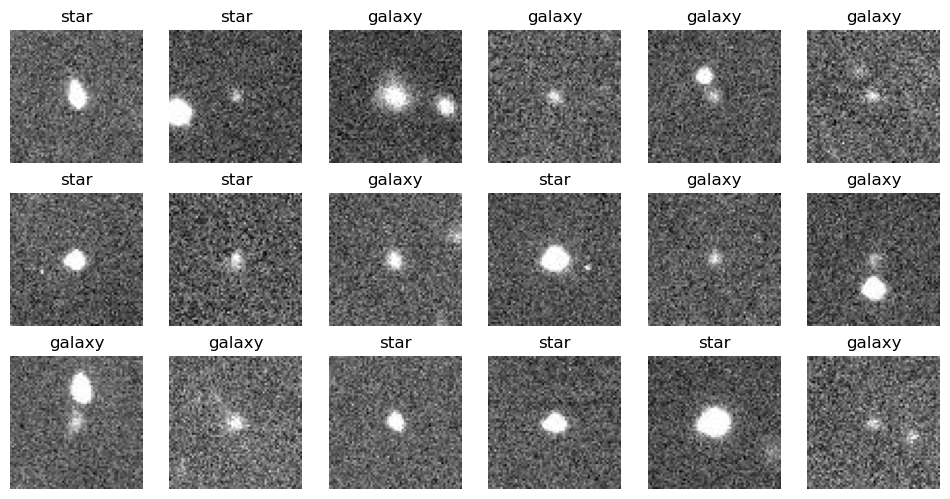

In [175]:
w, h = 6, 3

_, axs_list = plt.subplots(h, w, figsize=(2 * w, 2 * h))

_i = 0
indices = np.random.choice(len(X), size=(w * h))
for axs in axs_list:
    for ax in axs:
        i = indices[_i]
        ax.axis("off")
        img = X[i].reshape((64, 64))
        ax.imshow(img, cmap="gray")
        ax.set_title(sg.target_names[Y[i]])
        _i += 1

Now we can split the dataset into train and test sets.

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

## Building the Layers

Much like an onion or an ogre, a CNN model consists of layers.

In [177]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [178]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 12, 12, 64)        36928     
                                                                 
Total params: 55,744
Trainable params: 55,744
Non-trai

In [179]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [180]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 12, 12, 64)        36928     
                                                                 
 flatten_6 (Flatten)         (None, 9216)             

## Training the Model

In [181]:
model.compile(
    optimizer='adam',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test),
)

Epoch 1/10
45/45 [==============================] - 9s 186ms/step - loss: 0.7835 - accuracy: 0.5096 - val_loss: 0.7477 - val_accuracy: 0.4713
Epoch 2/10
45/45 [==============================] - 8s 174ms/step - loss: 0.6867 - accuracy: 0.5704 - val_loss: 0.6870 - val_accuracy: 0.5648
Epoch 3/10
45/45 [==============================] - 8s 176ms/step - loss: 0.6436 - accuracy: 0.6369 - val_loss: 0.6224 - val_accuracy: 0.6391
Epoch 4/10
45/45 [==============================] - 8s 182ms/step - loss: 0.5491 - accuracy: 0.7268 - val_loss: 0.5162 - val_accuracy: 0.7898
Epoch 5/10
45/45 [==============================] - 8s 183ms/step - loss: 0.5308 - accuracy: 0.7367 - val_loss: 0.5238 - val_accuracy: 0.7261
Epoch 6/10
45/45 [==============================] - 8s 184ms/step - loss: 0.4849 - accuracy: 0.7841 - val_loss: 0.4440 - val_accuracy: 0.8110
Epoch 7/10
45/45 [==============================] - 8s 181ms/step - loss: 0.4435 - accuracy: 0.8082 - val_loss: 0.4252 - val_accuracy: 0.8259
Epoch 

## Evaluating the Model

In [188]:
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

45/45 - 1s - loss: 0.3478 - accuracy: 0.8514 - 1s/epoch - 31ms/step
15/15 - 1s - loss: 0.3718 - accuracy: 0.8429 - 544ms/epoch - 36ms/step


Let's see how the model performed with each epoch. Here, we compare the accuracy with the training set (labeled "accuracy") with the accuracy with the test set (labeled "val_accuracy").

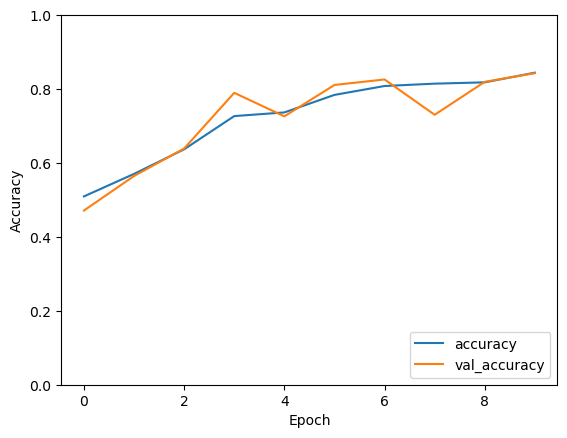

In [189]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

Let's also look at the loss with each epoch.

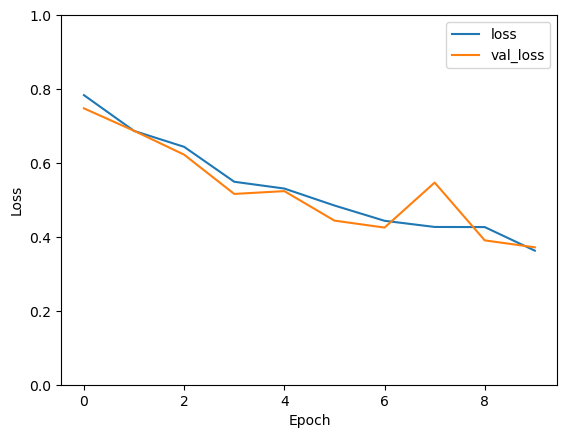

In [190]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')

Now, let's specifically see how accurate it is with galaxies.

In [191]:
galaxy_loss, galaxy_acc = model.evaluate(
    galaxies,
    np.full(galaxies_num, GALAXY),
    verbose=2,
)

30/30 - 1s - loss: 156.3985 - accuracy: 0.3004 - 888ms/epoch - 30ms/step


And let's compare that with its accuracy with just stars.

In [192]:
star_loss, star_acc = model.evaluate(
    stars,
    np.full(galaxies_num, STAR),
    verbose=2,
)

30/30 - 1s - loss: 1.4726 - accuracy: 0.9830 - 937ms/epoch - 31ms/step


## Conclusions

TBD